<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from scipy import stats as st
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


## Анализ данных

<div>
    <font color='green'>Информация о таблице с обучающей выборкой</font>
</div>

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


<div>
    <font color='green'>Информация о таблице с тестовой выборкой</font>
</div>

In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

<div>
    <font color='green'>Столбцы из обучающей выборки, которые отсутствуют в тестовой выборке.</font>
</div>

In [8]:
del_columns = []
for columns in data_train.columns:
    if columns not in data_test.columns:
        print(columns)
        del_columns.append(columns.replace('/n', ''))

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

**В тестовой таблице отсутствуют целевые признаки и признаки, которые выходят позже предсказания**

<div>
    <font color='green'>Вычисление эффективности обогащения по формуле для au</font>
</div>

In [9]:
data_train['recovery'] = data_train['rougher.output.concentrate_au']*(data_train['rougher.input.feed_au']-\
data_train['rougher.output.tail_au'])/(data_train['rougher.input.feed_au']*(data_train['rougher.output.concentrate_au']\
-data_train['rougher.output.tail_au']))*100
data_train[['rougher.output.recovery', 'recovery']]
                                                                                 


,rougher.output.recovery,recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
14144,89.574376,89.574376
14145,87.724007,87.724007
14146,88.890579,88.890579
14147,89.858126,89.858126


<div>
    <font color='green'>Метрика mae для вычисленной эффективности обогащения и приведённой в таблице</font>
</div>

In [10]:
mean_absolute_error(data_train['rougher.output.recovery'], data_train['recovery'])


9.73512347450521e-15

In [11]:
data_test = data_test.merge(data[['rougher.output.recovery', 'final.output.recovery', 'date']],\
how = 'inner', on = 'date')

<div>
    <font color='green'>Удаление столбца recovery</font>
</div>

In [12]:
data_train.drop('recovery', axis=1, inplace=True)

<div>
    <font color='green'>Удаление пропусков</font>
</div>

In [13]:
data_train.dropna(inplace=True)
data_test.dropna(inplace=True)
data.dropna(inplace=True)

<div>
    <font color='green'>Функция для построения средних значений концентраций в зависимости от 
    этапов очистки для au, ag, pb</font>
</div>

In [14]:
def plot(column1, column2, column3, column4):
    data_clearing = data_train[[column1, column2, column3, column4]]
    data_clearing.mean()
    data_clearing.columns = ['исходное сырьё', 'перед 1 очисткой', 'после 1 очистки', 'после 2 очистки']
    data_clearing.mean().plot(kind='bar', rot=0, figsize=(7, 4))
    plt.show()

<div>
    <font color='green'>Построение графиков</font>
</div>

Au


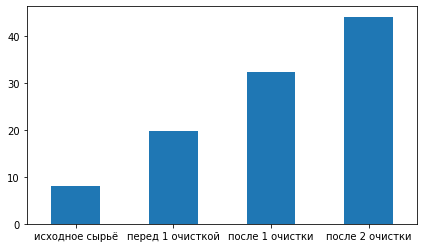

Ag


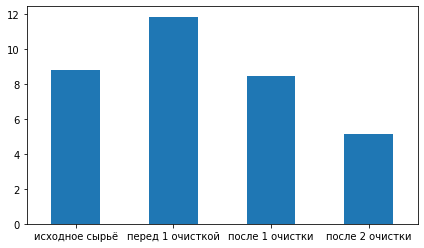

Pb


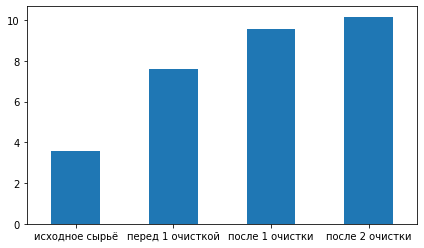

In [15]:
print('Au')
plot('rougher.input.feed_au','rougher.output.concentrate_au' ,'primary_cleaner.output.concentrate_au', \
            'final.output.concentrate_au')
print('Ag')
plot('rougher.input.feed_ag', 'rougher.output.concentrate_ag' ,'primary_cleaner.output.concentrate_ag', \
            'final.output.concentrate_ag')
print('Pb')
plot('rougher.input.feed_pb', 'rougher.output.concentrate_pb' ,'primary_cleaner.output.concentrate_pb', \
            'final.output.concentrate_pb')
        

**У Au средняя концентрация стабильно повышается с каждым этапом. У Ag имеется пик перед первой очисткой, но затем значение понижается и к концу становится ниже значения средней концентрации в сырье. У Pb незначительно повышается.**

<div>
    <font color='green'>Графики распределения размеров гранул сырья в обучающей и тестовой выборках </font>
    </div>

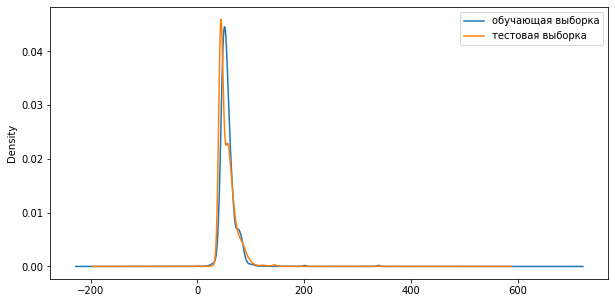

In [16]:
data_plot = pd.DataFrame({'обучающая выборка':data_train['rougher.input.feed_size'],\
                          'тестовая выборка':data_test['rougher.input.feed_size']})
data_plot.plot.kde(figsize=(10, 5))

plt.show()


**Распределения мало отличаются.**

<div>
    <font color='green'>Суммарная концентрация всех веществ на разных этапах</font>
</div>

In [17]:
data['rougher.input.feed_sum'] = data['rougher.input.feed_au'] + data['rougher.input.feed_ag'] + \
data['rougher.input.feed_pb'] + data['rougher.input.feed_sol']

data['rougher.output.concentrate_sum'] = data['rougher.output.concentrate_au'] + \
data['rougher.output.concentrate_ag'] +data['rougher.output.concentrate_pb'] + data['rougher.output.concentrate_sol']

data['primary_cleaner.output.concentrate_sum'] = data['primary_cleaner.output.concentrate_au'] + \
data['primary_cleaner.output.concentrate_ag'] + data['primary_cleaner.output.concentrate_pb'] +\
data['primary_cleaner.output.concentrate_sol']

data['final.output.concentrate_sum'] = data['final.output.concentrate_au'] + \
data['final.output.concentrate_ag'] + data['final.output.concentrate_pb'] + data['final.output.concentrate_sol']




Расспределение суммы всех веществ для этапа сырья


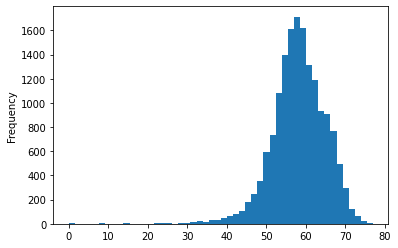

Расспределение суммы всех веществ для чернового этапа


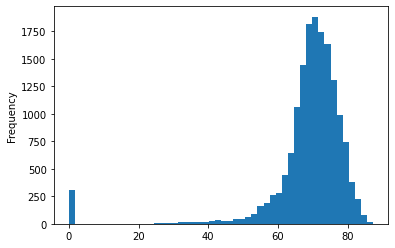

Расспределение суммы всех веществ после первой очистки


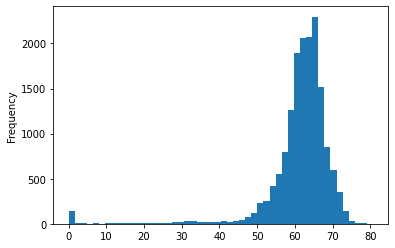

Расспределение суммы всех веществ для финального этапа


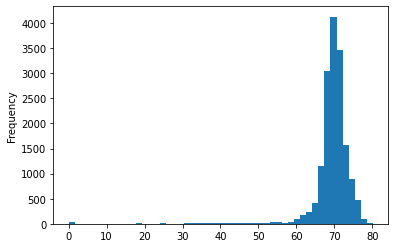

In [18]:
print("Расспределение суммы всех веществ для этапа сырья")
data['rougher.input.feed_sum'].plot.hist(bins=50)
plt.show()
print("Расспределение суммы всех веществ для чернового этапа")
data['rougher.output.concentrate_sum'].plot.hist(bins=50)
plt.show()
print("Расспределение суммы всех веществ после первой очистки")
data['primary_cleaner.output.concentrate_sum'].plot.hist(bins=50)
plt.show()
print("Расспределение суммы всех веществ для финального этапа")
data['final.output.concentrate_sum'].plot.hist(bins=50)
plt.show()

<div>
    <font color='green'>Удаление аномалий в распределениях суммы всех 4-ёх веществ по каждаму этапу</font>
    </div>

In [19]:
for col in ['rougher.input.feed_sum', 'rougher.output.concentrate_sum', \
            'primary_cleaner.output.concentrate_sum', 'final.output.concentrate_sum']:
    data = data[data[col]>20]

In [20]:
data_train = data_train.set_index('date')
data = data.set_index('date')
data_train = data_train.loc[data_train.index.isin(data.index)]

**Самое узкое и высокое получилось распределение после финального этапа. Это может говорить о близких к  постоянству результатах. Самое широкое - на этапе сырья. Также были обнаруженны аномалии в распределениях сумм 4-ёх веществ по этапам и по датам, которые были удаленны.**


<div>
    <font color='green'>Функция для рассчёта метрики smape</font>
</div>

In [21]:
def smape(target, predict):
    numerator = abs(target-predict)
    denominator = (abs(target)+abs(predict))/2
    smape = ((numerator/denominator).sum()/target.shape[0])*100
    return smape
def final_smape(smape_r, smape_f):
    return (0.25*smape_r + 0.75*smape_f)

<div>
    <font color='green'>Удаление признаков из data_train. Обучающие и тестовые признаки. Целевые признаки rougher.output.recovery
    и final.output.recovery</font>
</div>

In [22]:
columns_for_model = ['rougher.output.recovery', 'final.output.recovery']
for col in del_columns:
    if col not in columns_for_model:
        data_train.drop([col], axis=1, inplace=True)
    

In [23]:
data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

In [24]:
data_test.drop('date', axis=1, inplace=True)

In [25]:
features_train_r = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_r = data_train['rougher.output.recovery']


features_test_r = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_r = data_test['rougher.output.recovery']


In [26]:
features_train_f = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_f = data_train['final.output.recovery']

features_test_f = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_f = data_test['final.output.recovery']

<div>
    <font color='green'>Функция для поиска лучшей модели Случайного леса с помощью кросс-корреляции</font>
</div>

In [27]:
def scores_model(features, target, features2, target2):
    final_smape_best = 1000
    best_model = None
    best_est = 0
    best_depth = 0
    for est in tqdm(range(1, 20)):
        for depth in range (1, 11):
            model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
            #сразу для двух признаков
            scores = cross_val_score(model, features, target, cv=5, scoring=make_scorer(smape, \
                                                                                 greater_is_better=False))
            scores2 = cross_val_score(model, features2, target2, cv=5, scoring=make_scorer(smape, \
                                                                                 greater_is_better=False))
            final_score = abs(sum(scores)/len(scores))
            final_score2 = abs(sum(scores2)/len(scores2))
            #итоговая smape
            final_sm = final_smape(final_score, final_score2)
            if final_sm < final_smape_best:
                final_smape_best = final_sm
                best_model = model
                best_est = est
                best_depth = depth
    print(best_model)
    return final_smape_best



<div>
    <font color='green'>Функция для модели Линейной регрессии</font>
</div>

In [28]:
def linear_model(features, target, features2, target2):
    model = LinearRegression()
    scores = cross_val_score(model, features, target, cv=5, scoring=make_scorer(smape, \
                                                                                 greater_is_better=False))
    scores2 = cross_val_score(model, features, target, cv=5, scoring=make_scorer(smape, \
                                                                                 greater_is_better=False))
    final_score = sum(scores)/len(scores)
    final_score2 = sum(scores2)/len(scores2)
    final_sm = final_smape(final_score, final_score2)
    print(model)
    return abs(final_sm)

<div>
    <font color='green'>Обучение моделей и выбор лучшей</font>
</div>


In [ ]:
scores_model(features_train_r, target_train_r, features_train_f, target_train_f)

In [29]:
print('Значение лучшей smape для модели Линейной регрессии:', linear_model(features_train_r, target_train_r, \
                                                 features_train_f, target_train_f))

LinearRegression()
Значение лучшей smape для модели Линейной регрессии: 6.096320698742099


**По перебору итоговой sMAPE с наименьшим значением метрики стала модель Линейной регрессии. Значение итоговой sMAPE вышло равным 6.096320698742099. Среди моделей с различными гиперпараметрами Случайного леса - с наименьшей итоговой sMAPE вышла модель с глубиной деревьев равной 4 и колличеством деревьев, равным 18. Значение метрики равно 6.766582273034956.**

## Модель

<div>
    <font color='green'>Обучение модели Линейной регрессии и предсказание признаков final.output.recovery и rougher.output.recovery. Метрики smape и итоговые smape</font>
</div>

In [30]:
model_rougher = LinearRegression()
model_rougher.fit(features_train_r, target_train_r)
prediction_r = model_rougher.predict(features_test_r)


In [31]:
smape_rougher = smape(target_test_r, prediction_r)
print('Метрика качества sMAPE для признака rougher.output.recovery:', smape_rougher)

Метрика качества sMAPE для признака rougher.output.recovery: 8.33654799159304


In [32]:
model_final = LinearRegression()
model_final.fit(features_train_f, target_train_f)
prediction_f = model_final.predict(features_test_f)

In [33]:
smape_final = smape(target_test_f, prediction_f)
print('Метрика качества sMAPE для признака final.output.recovery:', smape_final)

Метрика качества sMAPE для признака final.output.recovery: 8.960799148250695


In [34]:
fin_smape = final_smape(smape_rougher, smape_final)
print('Итоговая sMAPE:', fin_smape)

Итоговая sMAPE: 8.80473635908628


<div>
    <font color='green'>Сравнение с константной моделью</font>
    </div>


In [35]:
dummy_r = DummyRegressor(strategy='median')
dummy_r.fit(features_train_r, target_train_r)
prediction_r = dummy_r.predict(features_test_r)
dummy_smape_rougher = smape(target_test_r, prediction_r)


dummy_f = DummyRegressor(strategy='median')
dummy_f.fit(features_train_f, target_train_f)
prediction_f = dummy_f.predict(features_test_f)
dummy_smape_final = smape(target_test_f, prediction_f)

print('Итоговая smape у константной модели:', final_smape(dummy_smape_rougher, dummy_smape_final))


Итоговая smape у константной модели: 9.126338756101312


**Вывод:\
\
Лучше всего добыть вещество из руды получается у au. Cредняя концентрация стабильно и заметно повышается к финальному продукту и имеет высокие значения по сравнению с другими веществами. У Ag имеется пик перед первой очисткой, но затем значение понижается и к концу становится ниже значения средней концентрации в сырье. У pb также повышается концентрация, но заметно слабее. У ag и sol концентрации к финальному продукту понижаются.\
\
При построении распределений сумм 4-ёх веществ для каждого этапа, выявилось, что самое узкое и высокое получилось распределение после финального этапа. Это может говорить о близких к  постоянству результатах. Самое широкое - на этапе сырья. Также были обнаруженны аномалии в распределениях сумм 4-ёх веществ по датам для каждого из 4-ёх этапов, которые были удаленны.\
\
Из рассмотренных моделей лучшей стала модель Линейной регрессии. Значение итоговой sMAPE на тренировочной выборке вышло равным 6.096320698742099. Среди моделей с различными гиперпараметрами Случайного леса - с наименьшей итоговой sMAPE вышла модель с глубиной деревьев равной 4 и колличеством деревьев, равным 18. Значение метрики равно 6.766582273034956.\
\
На тестовых выборках модель Линейной регрессии предсказала целевые признаки rougher.output.recovery и final.output.recovery с итоговой smape равной 8.80473635908628. Итоговая smape у константной модели вышла больше, чем у модели Линейной регрессии и равна 9.126338756101312.**
    